In [1]:
import pandas as pd
from sodapy import Socrata
import plotly.express as px
import nbformat
import matplotlib.pyplot as plt
from datetime import *
import statsmodels.api as sm
import seaborn as sns
import plotly.io as pio
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as sp
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.impute import SimpleImputer
from statsmodels.tsa.api import SimpleExpSmoothing

import warnings

# Filter out the specific warning messages
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')



In [2]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/k46n-sa2m
client = Socrata("data.cityofnewyork.us", None)
results = client.get("k46n-sa2m",limit=80000)

# Convert to pandas DataFrame
dhs_daily_df = pd.DataFrame.from_records(results)

In [3]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/6z8x-wfk4
client = Socrata("data.cityofnewyork.us", None)
results = client.get("6z8x-wfk4",limit=80000)

# Convert to pandas DataFrame
evictions_df = pd.DataFrame.from_records(results)

In [4]:
#converting to type numeric
cols = dhs_daily_df.columns.drop('date_of_census')
dhs_daily_df[cols] = dhs_daily_df[cols].apply(pd.to_numeric)
dhs_daily_df['date_of_census'] = pd.to_datetime(dhs_daily_df['date_of_census'])

In [5]:
evictions_df['executed_date'] = pd.to_datetime(evictions_df['executed_date'])

In [6]:

# Create a list to store the new column names
new_columns = []

# Iterate over each column
for column in dhs_daily_df.columns:
    if column != 'total_individuals_in_shelter' and column != 'date_of_census':
        # Generate the new column name with the prefix "perc_" followed by the original column name
        new_column = 'perc_' + column
        
        # Divide the values in the current column by the values in the 'total_individuals_in_shelter' column
        new_values = ((dhs_daily_df[column].astype(float) / dhs_daily_df['total_individuals_in_shelter'].astype(float))*100).round(2)
        
        # Append the new column to the DataFrame
        dhs_daily_df[new_column] = new_values
        
        # Append the new column name to the list
        new_columns.append(new_column)

In [7]:
# Set the 'date' column as the index
dhs_daily_df.set_index('date_of_census', inplace=True)

In [8]:
counts_by_boro_piv = pd.pivot_table(evictions_df,values='docket_number', aggfunc='count',index='executed_date',columns='borough').reset_index().sort_values(by='executed_date',ascending=False)


In [9]:
# Convert 'executed_date' column to datetime
counts_by_boro_piv['executed_date'] = pd.to_datetime(counts_by_boro_piv['executed_date'])


In [10]:
# create new dataframe with eviction counts
evictions_counts_df = evictions_df.groupby('executed_date')['docket_number'].count().reset_index()

# Rename the count column to 'count_of_docket_numbers'
evictions_counts_df = evictions_counts_df.rename(columns={'docket_number': 'eviction_count'})

In [11]:
# Merge the two DataFrames based on the 'executed_date' column
merged_df = pd.merge(dhs_daily_df, evictions_counts_df, left_on='date_of_census', right_on='executed_date')

# Multiply 'eviction_count' by arbitrary number of 10 to normalize given the limitations of the dataset
merged_df['eviction_count'] = merged_df['eviction_count'] * 10


# Forecasting Models

### Simple Moving Average

In [12]:
merged_df.set_index('executed_date', inplace=True)

In [13]:
window_size = 2
sma = merged_df['total_individuals_in_shelter'].rolling(window_size).mean().dropna()
actual_values = merged_df['total_individuals_in_shelter'][window_size-1:].reset_index(drop=True)

# Calculate MAE and RMSE
sma_rmse = np.sqrt(mean_squared_error(actual_values, sma))
sma_mae = mean_absolute_error(actual_values, sma)

print("Root Mean Squared Error (RMSE):", sma_rmse)
print("Mean Absolute Error (MAE):", sma_mae)

Root Mean Squared Error (RMSE): 104.07947947510482
Mean Absolute Error (MAE): 59.24900398406375


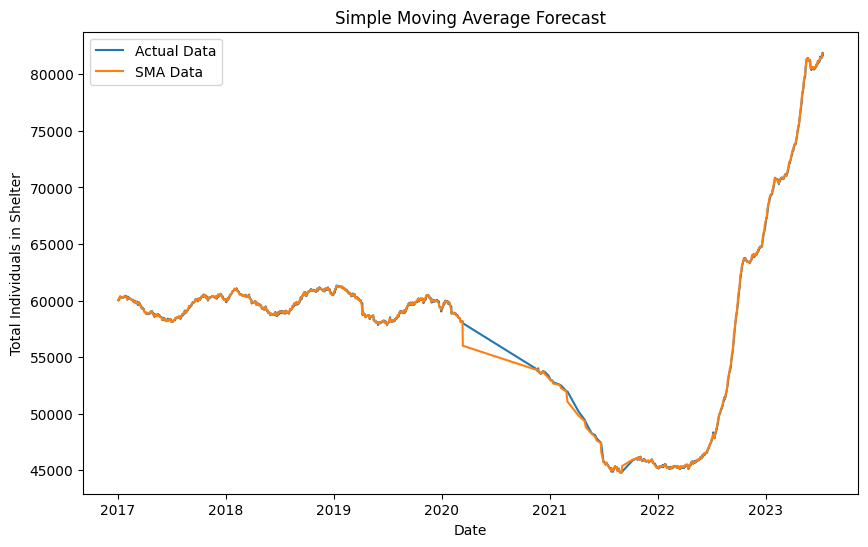

In [14]:
# Plot the actual values and the SMA values
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['total_individuals_in_shelter'], label='Actual Data')
plt.plot(sma.index, sma, label='SMA Data')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Individuals in Shelter')
plt.title('Simple Moving Average Forecast')
plt.show()


### Exponential Smoothing

In [15]:
# Calculate the split point
split_point = int(len(merged_df) * 0.8)

# Split the data into training and testing sets
train = merged_df[:split_point]
test = merged_df[split_point:]

# Check the sizes of the training and testing sets
#len(train), len(test)


In [16]:

# Create a Simple Exponential Smoothing model
model = SimpleExpSmoothing(train['total_individuals_in_shelter'].values)

# Fit the model
model_fit = model.fit()

# Forecast on the test set
ses_test_predictions = model_fit.predict(len(train), len(merged_df)-1)

# Calculate MAE and RMSE
ses_mae = mean_absolute_error(test['total_individuals_in_shelter'], ses_test_predictions)
ses_rmse = np.sqrt(mean_squared_error(test['total_individuals_in_shelter'], ses_test_predictions))


print("Root Mean Squared Error (RMSE):", ses_rmse)
print("Mean Absolute Error (MAE):", ses_mae)


Root Mean Squared Error (RMSE): 1638.8336750529081
Mean Absolute Error (MAE): 1415.5656569509395


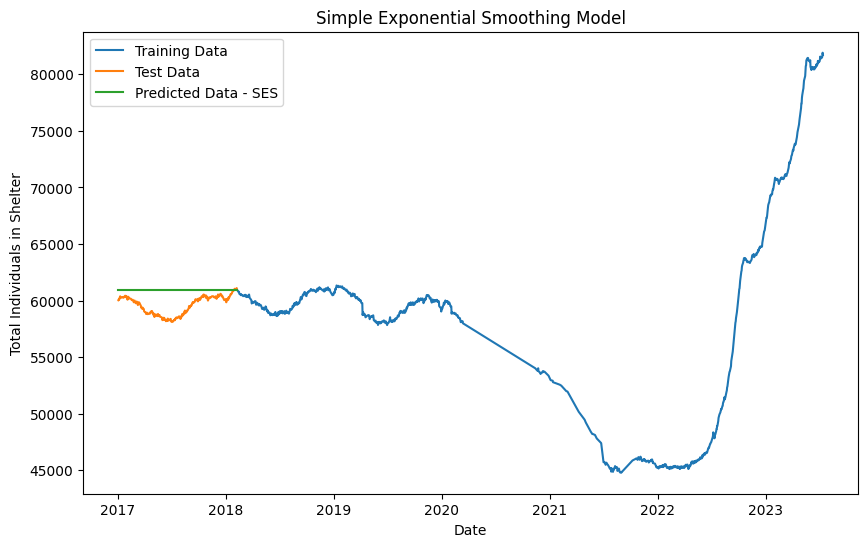

In [21]:
# Plot the actual values and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['total_individuals_in_shelter'], label='Training Data')
plt.plot(test.index, test['total_individuals_in_shelter'], label='Test Data')
plt.plot(test.index, ses_test_predictions, label='Predicted Data - SES')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Individuals in Shelter')
plt.title('Simple Exponential Smoothing Model')
plt.show()

### Seasonal Naive Model

In [23]:
# Create a Naive model
naive_test_predictions = [train['total_individuals_in_shelter'].values[-1]] * len(test)

# Calculate MAE and RMSE
naive_mae = mean_absolute_error(test['total_individuals_in_shelter'], naive_test_predictions)
naive_rmse = np.sqrt(mean_squared_error(test['total_individuals_in_shelter'], naive_test_predictions))


print("Root Mean Squared Error (RMSE):", naive_rmse)
print("Mean Absolute Error (MAE):", naive_mae)



Root Mean Squared Error (RMSE): 1639.0312615049404
Mean Absolute Error (MAE): 1415.7857142857142


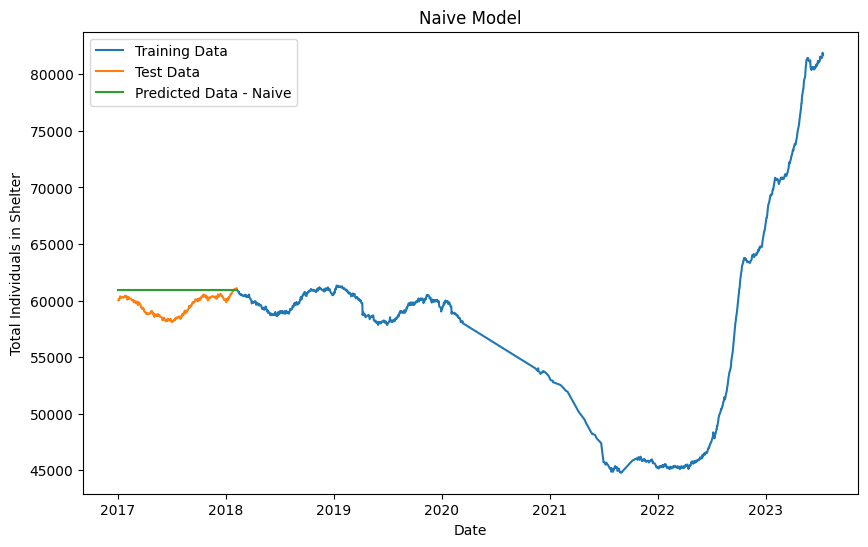

In [24]:
# Plot the actual values and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['total_individuals_in_shelter'], label='Training Data')
plt.plot(test.index, test['total_individuals_in_shelter'], label='Test Data')
plt.plot(test.index, naive_test_predictions, label='Predicted Data - Naive')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Individuals in Shelter')
plt.title('Naive Model')
plt.show()

The plot above shows the actual number of individuals in shelter and the values predicted by the Naive model.

In this case, the Naive model simply uses the last observed value of the training set to make predictions for the entire test set, which is why the predicted values are a flat line.

From these metrics and the plot, we can see that the model's performance is not very good due to the simplicity of its approach.

### ARIMA Model

In [25]:
# Create an ARIMA model
model = ARIMA(train['total_individuals_in_shelter'], order=(1, 1, 1))

# Fit the model
model_fit = model.fit()

# Forecast on the test set
arima_test_predictions = model_fit.predict(start=len(train), end=len(merged_df)-1, dynamic=False)

# Calculate MAE and RMSE
arima_mae = mean_absolute_error(test['total_individuals_in_shelter'], arima_test_predictions)
arima_rmse = np.sqrt(mean_squared_error(test['total_individuals_in_shelter'], arima_test_predictions))


print("Root Mean Squared Error (RMSE):", arima_rmse)
print("Mean Absolute Error (MAE):", arima_mae)



Root Mean Squared Error (RMSE): 2290.001072314249
Mean Absolute Error (MAE): 2090.676720257368


/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


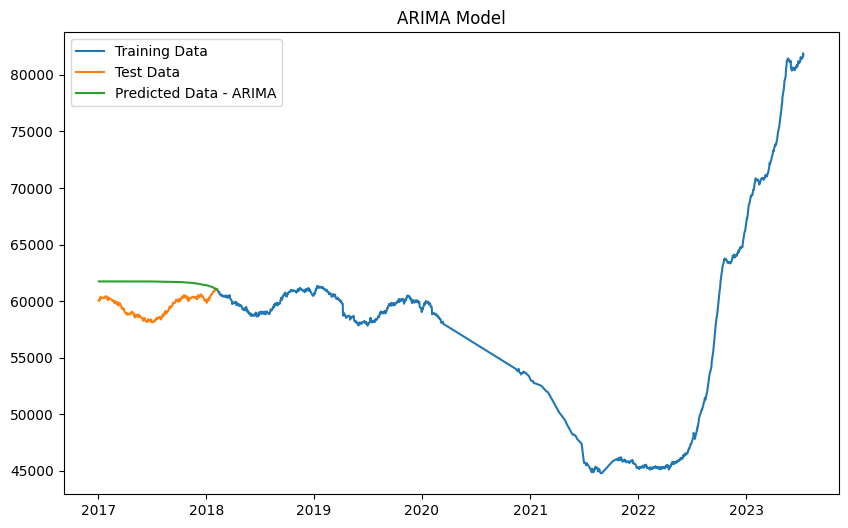

In [26]:

# Plot the actual values and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['total_individuals_in_shelter'], label='Training Data')
plt.plot(test.index, test['total_individuals_in_shelter'], label='Test Data')
plt.plot(test.index, arima_test_predictions, label='Predicted Data - ARIMA')
plt.legend(loc='best')
plt.title('ARIMA Model')
plt.show()

## Compare Models

In [27]:
# Create a dataframe to hold the results
results = pd.DataFrame({
    'Model': ['Simple Moving Average', 'Exponential Smoothing', 'Naive', 'ARIMA'],
    'MAE': [sma_mae, ses_mae, naive_mae, arima_mae],
    'RMSE': [sma_rmse, ses_rmse, naive_rmse, arima_rmse]
})

# Display the results
results

,Model,MAE,RMSE
0,Simple Moving Average,59.249004,104.079479
1,Exponential Smoothing,1415.565657,1638.833675
2,Naive,1415.785714,1639.031262
3,ARIMA,2090.676720,2290.001072


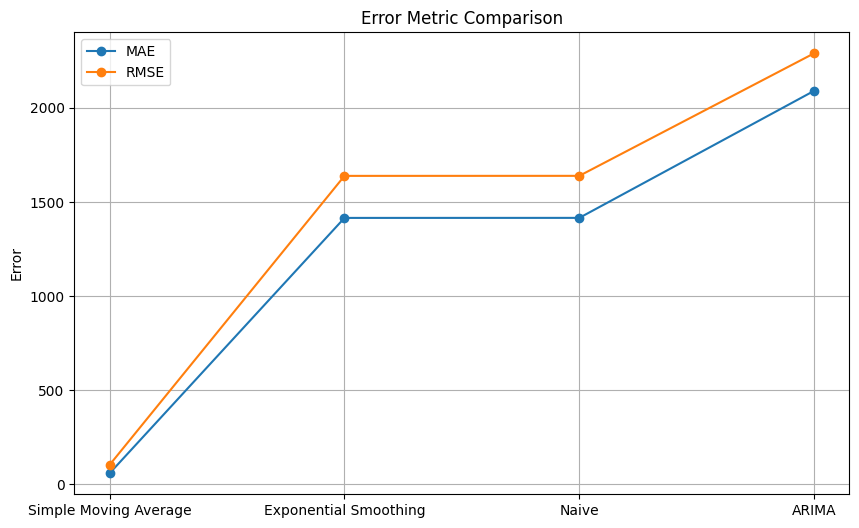

In [28]:
# Plot the MAE and RMSE for each model in a single line chart
plt.figure(figsize=(10, 6))
plt.plot(results['Model'], results['MAE'], marker='o', label='MAE')
plt.plot(results['Model'], results['RMSE'], marker='o', label='RMSE')
plt.title('Error Metric Comparison')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost Model

In [29]:
# Merge the two DataFrames based on the 'executed_date' column
data = pd.merge(dhs_daily_df, evictions_counts_df, left_on='date_of_census', right_on='executed_date')

In [30]:
# Extract relevant date features
data['year'] = data['executed_date'].dt.year
data['month'] = data['executed_date'].dt.month
data['day'] = data['executed_date'].dt.day
data['day_of_week'] = data['executed_date'].dt.dayofweek

In [31]:
# Define the features to drop
features_to_drop = [
    'total_individuals_in_shelter', 'total_adults_in_shelter', 'total_children_in_shelter',
    'single_adult_men_in_shelter', 'single_adult_women_in_shelter', 'total_single_adults_in_shelter',
    'families_with_children_in_shelter', 'adults_in_families_with_children_in_shelter',
    'children_in_families_with_children_in_shelter',
    'total_individuals_in_families_with_children_in_shelter_',
    'adult_families_in_shelter', 'individuals_in_adult_families_in_shelter',
    'perc_total_adults_in_shelter', 'perc_total_children_in_shelter',
    'perc_single_adult_men_in_shelter', 'perc_single_adult_women_in_shelter',
    'perc_total_single_adults_in_shelter', 'perc_families_with_children_in_shelter',
    'perc_adults_in_families_with_children_in_shelter',
    'perc_children_in_families_with_children_in_shelter',
    'perc_total_individuals_in_families_with_children_in_shelter_',
    'perc_adult_families_in_shelter', 'perc_individuals_in_adult_families_in_shelter', 'executed_date', 'eviction_count'
]

In [32]:
# Split the data into features (X) and target variable (y)
X = data.drop(features_to_drop, axis=1)
y = data[['total_individuals_in_shelter', 'total_adults_in_shelter', 'total_children_in_shelter', 'eviction_count']]


In [36]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
model = xgb.XGBRegressor()


In [37]:
# Define the hyperparameters to tune and their potential values
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

In [38]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
#print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
model = xgb.XGBRegressor(**best_params)

In [40]:
# Train the model
model.fit(X_train, y_train)

# Make forecasts on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = np.sqrt(mean_squared_error(y_test, y_pred)) 
print("Root Mean Squared Error:", mse)

Root Mean Squared Error: 124.16342833951333


In [43]:
# Forecast future values
future_date = pd.to_datetime('2023-07-15') 

In [44]:
future_features = pd.DataFrame({
    'year': [future_date.year],
    'month': [future_date.month],
    'day': [future_date.day],
    'day_of_week': [future_date.dayofweek]
})

In [48]:
future_forecast = model.predict(future_features)

In [49]:
# Define the labels for the forecast
labels = ['total_individuals_in_shelter', 'total_adults_in_shelter', 'total_children_in_shelter', 'eviction_count']

# Print the future forecast with labels
print("Future Forecast:")
for label, forecast in zip(labels, future_forecast[0]):
    print(label + ':', forecast)

Future Forecast:
total_individuals_in_shelter: 81689.88
total_adults_in_shelter: 53466.258
total_children_in_shelter: 28133.133
eviction_count: 12.880685
